## Load Dataset

In [1]:
!gdown --id 1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639
!unzip img_cls_scenes_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: scenes_classification/train/mountain/16162.jpg  
  inflating: scenes_classification/train/mountain/16173.jpg  
  inflating: scenes_classification/train/mountain/16225.jpg  
  inflating: scenes_classification/train/mountain/16322.jpg  
  inflating: scenes_classification/train/mountain/16341.jpg  
  inflating: scenes_classification/train/mountain/16350.jpg  
  inflating: scenes_classification/train/mountain/16374.jpg  
  inflating: scenes_classification/train/mountain/16375.jpg  
  inflating: scenes_classification/train/mountain/16417.jpg  
  inflating: scenes_classification/train/mountain/1642.jpg  
  inflating: scenes_classification/train/mountain/16421.jpg  
  inflating: scenes_classification/train/mountain/16438.jpg  
  inflating: scenes_classification/train/mountain/16560.jpg  
  inflating: scenes_classification/train/mountain/16599.jpg  
  inflating: scenes_classification/train/mountain/16645.jpg  
  inflating: scenes_

In [2]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

In [4]:
root_dir = 'scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(train_dir))
        )
}

X_train, y_train, X_test, y_test = [], [], [], []
for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

In [5]:
classes

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [6]:
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

## Pytorch Dataset

In [7]:
class ScenesDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

## Data Preprocessing

In [8]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float() # move channel to the front
    normalized_img = img / 255.0

    return normalized_img

In [9]:
train_batch_size = 64
test_batch_size = 8

train_dataset = ScenesDataset(X_train, y_train, transform=transform)
val_dataset = ScenesDataset(X_val, y_val, transform=transform)
test_dataset = ScenesDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

torch.Size([64, 3, 224, 224])
torch.Size([64])


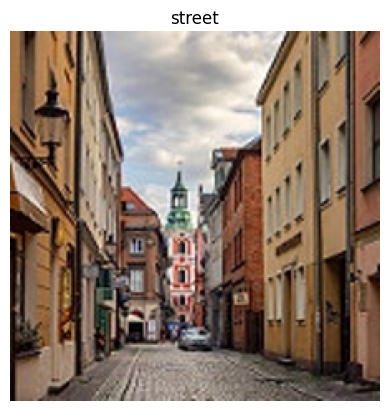

In [10]:
img_samples, label_samples = next(iter(train_loader))
print(img_samples.shape)
print(label_samples.shape)

img_sample = img_samples[0]
plt.imshow(img_sample.permute(1, 2, 0))
plt.title(classes[label_samples[0].item()])
plt.axis('off')
plt.show()

## Model Training


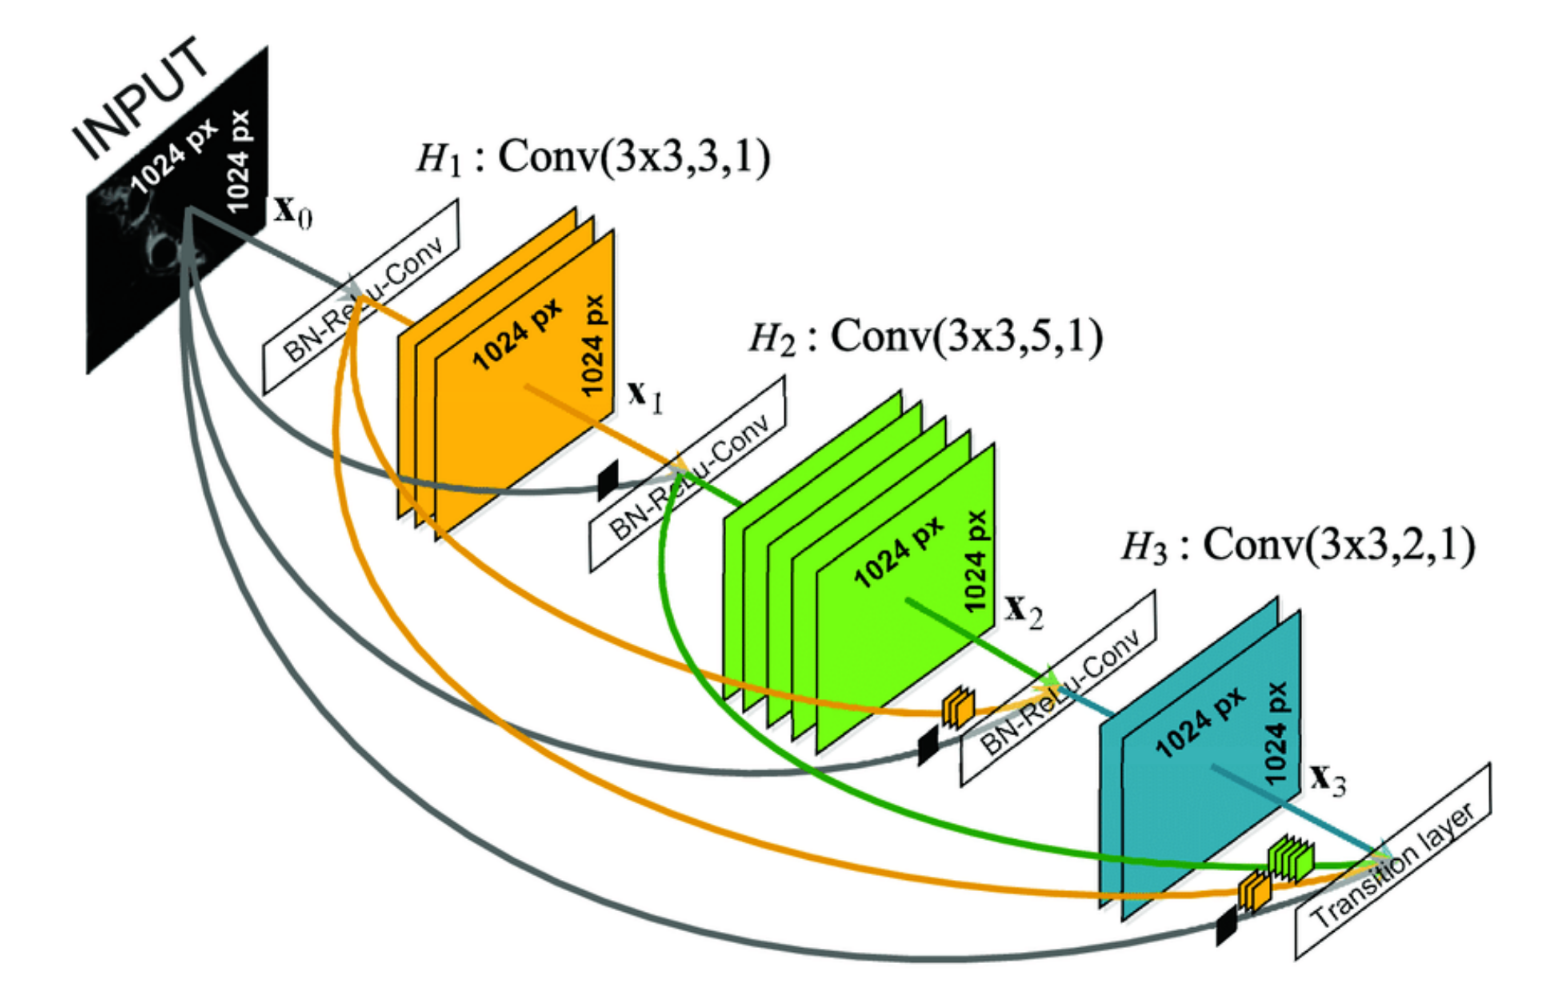

In [11]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x.clone().detach()
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = torch.cat([res, out], dim=1)

        return out

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [12]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        # Transition layers
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                ))
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool1(out)

        for block in self.dense_blocks:
            out = block(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.pool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [13]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DenseNet(
    [6, 12, 24, 16],
    growth_rate=32,
    num_classes=n_classes
).to(device)

In [14]:
model.eval()
dummy_tensor = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(dummy_tensor)
print('Output shape:', output.shape)

Output shape: torch.Size([1, 6])


## **8. Training**

In [15]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [16]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [17]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH 1:	Train loss: 1.4377	Val loss: 1.2779
EPOCH 2:	Train loss: 1.2164	Val loss: 1.1826
EPOCH 3:	Train loss: 1.1272	Val loss: 1.1030
EPOCH 4:	Train loss: 1.0676	Val loss: 1.0491
EPOCH 5:	Train loss: 1.0187	Val loss: 0.9967
EPOCH 6:	Train loss: 0.9715	Val loss: 0.9492
EPOCH 7:	Train loss: 0.9287	Val loss: 0.9122
EPOCH 8:	Train loss: 0.8854	Val loss: 0.8666
EPOCH 9:	Train loss: 0.8506	Val loss: 0.8416
EPOCH 10:	Train loss: 0.8178	Val loss: 0.8091
EPOCH 11:	Train loss: 0.7905	Val loss: 0.8184
EPOCH 12:	Train loss: 0.7590	Val loss: 0.7807
EPOCH 13:	Train loss: 0.7332	Val loss: 0.7791
EPOCH 14:	Train loss: 0.6993	Val loss: 0.7265
EPOCH 15:	Train loss: 0.6712	Val loss: 0.6931
EPOCH 16:	Train loss: 0.6531	Val loss: 0.9606
EPOCH 17:	Train loss: 0.6221	Val loss: 0.6645
EPOCH 18:	Train loss: 0.5921	Val loss: 0.6474
EPOCH 19:	Train loss: 0.5748	Val loss: 0.6446
EPOCH 20:	Train loss: 0.5474	Val loss: 0.7505
EPOCH 21:	Train loss: 0.5247	Val loss: 0.6188
EPOCH 22:	Train loss: 0.4988	Val loss: 0.62

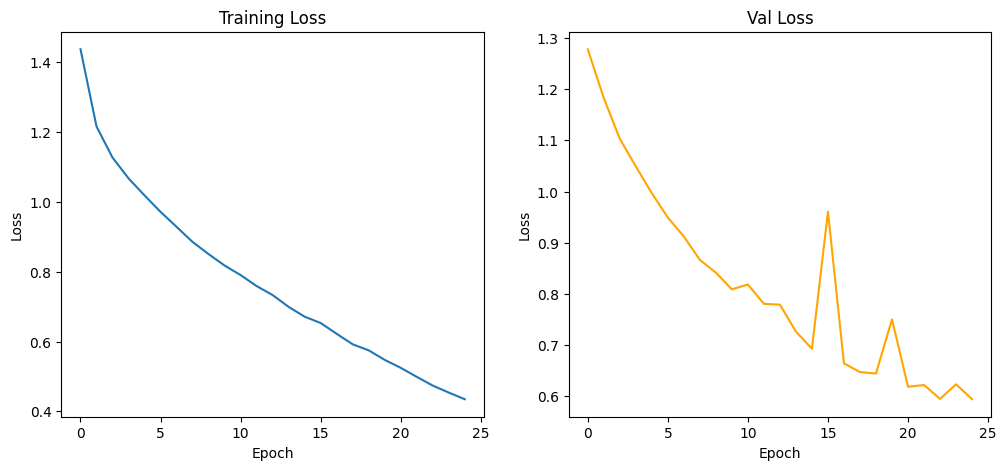

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## **9. Evaluation**

In [19]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.7784111150694691
Test accuracy:  0.7863333333333333
